In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow


In [2]:
# %%time
files = sorted(glob('spicy_s1_stacks/*.nc'))

# Create parameter space
A = 2.5
B = 0.2
C = 0.55

wet_snow_thresh = np.arange(4, -4, -0.1)
#wet_snow_thresh = np.arange(-4, -1, 1)

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')
    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays
    rmse_wet_flag = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,
                        coords={'wet_snow_thresh':wet_snow_thresh}, dims=('wet_snow_thresh'))
    rmse_no_flag = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,
                        coords={'wet_snow_thresh':wet_snow_thresh}, dims=('wet_snow_thresh'))
    
    # Brute-force loop

    for wst in wet_snow_thresh:
        print(f'A={A}; B={B}; C={C}; wst={wst}')
        ds = calc_delta_cross_ratio(dataset, A=A, inplace=False)
        ds = calc_delta_gamma(ds, B=B, inplace=False)
        
        ds = clip_delta_gamma_outlier(ds)
        ds = calc_snow_index(ds)
        ds = calc_snow_index_to_snow_depth(ds, C=C, inplace=False)
        ds = id_newly_wet_snow(ds,wet_thresh=wst)
        ds = id_wet_negative_si(ds)
        ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
        ds = flag_wet_snow(ds)
        # Compare snow depths - mask wet snow
        mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                ds['wet_snow'].sel(time=closest_ts).astype(bool))
        diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
        rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
        print(f'RMSE wet = {rmse_wet}')
        rmse_wet_flag.loc[wst] = rmse_wet
        # Compare snow depths - no wet snow mask
        mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
        diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
        rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
        print(f'RMSE = {rmse}')
        rmse_no_flag.loc[wst] = rmse

    # After loop, save RMSE results per file
    rmse_wet_flag.to_netcdf(f'rmse_out/{ds_name}_wet_flag.nc')
    rmse_no_flag.to_netcdf(f'rmse_out/{ds_name}_no_flag.nc')
    

2023-06-08 23:34:52.084923  -- starting Banner_2020-02-18
A=2.5; B=0.2; C=0.55; wst=4.0
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.9
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.8
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.6999999999999997
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.5999999999999996
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.4999999999999996
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.3999999999999995
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.2999999999999994
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.1999999999999993
RMSE wet = 0.7210630663565644
RMSE = 0.7210630663565644
A=2.5; B=0.2; C=0.55; wst=3.099999999999999
RMSE wet = 0.7210630663565644
RMSE

/tmp/ipykernel_13694/2380410667.py:22: RuntimeWarning: invalid value encountered in multiply
  rmse_wet_flag = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,


RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.9
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.8
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.6999999999999997
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.5999999999999996
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.4999999999999996
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.3999999999999995
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.2999999999999994
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.1999999999999993
RMSE wet = 0.04272249496326915
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=3.099999999999999
RMSE wet = 0.04272249496326915
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=2.999999999999999
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; C=0.55; wst=2.899999999999999
RMSE wet = 0.0
RMSE = 0.8427495683839611
A=2.5; B=0.2; 

In [3]:
results = sorted(glob('rmse_out/*.nc'))
names = []
for f in results:
    if 'no_flag' in f:
        continue
    ds_name = f.split('rmse_out/')[-1]
    ds_name = ds_name.split('_wet')[0]
    names.append(ds_name)
thresh_results = pd.DataFrame(columns=names)

for f in results:
    if 'no_flag' in f:
        continue
    r = xr.open_dataarray(f).load()
    ds_name = f.split('rmse_out/')[-1]
    ds_name = ds_name.split('_wet')[0]
    for ind,val in zip(r.wet_snow_thresh.values,r.values):
        thresh_results.loc[ind,ds_name] = val

<Axes: >

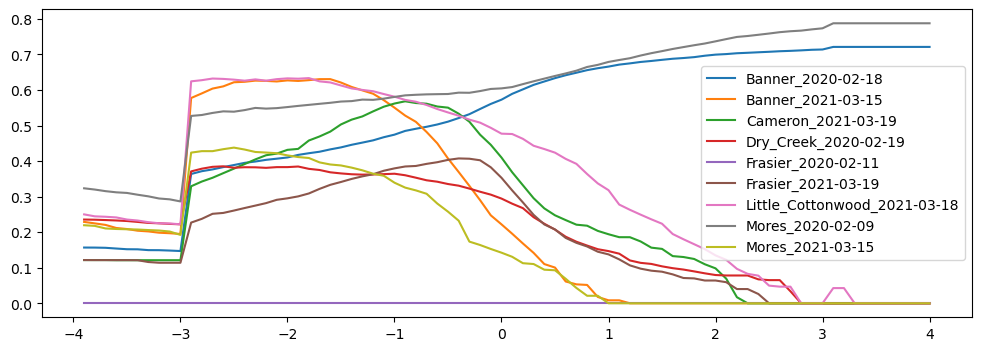

In [6]:
f,ax=plt.subplots(figsize=(12,4))
thresh_results.plot(ax=ax)

In [7]:
#thresh_results

In [8]:
#r.values

In [9]:
#r.wet_snow_thresh.values

In [10]:
#wst_list

In [11]:
# rmse_default = []
# ds_list = []

# res_default = pd.Series(rmse_default, index=ds_list)
# res_default

# results = sorted(glob('rmse_out/*.nc'))
# res_df = pd.DataFrame(res_default, columns=['rmse_default'])
# minn, a_list, b_list, c_list, wst_list= [], [], [], [], []
# for f in results:
#     if 'no_flag' in f:
#         continue
#     r = xr.open_dataarray(f).load()
#     ds_name = f.split('rmse_out/')[-1]
#     ds_name = ds_name.split('_wet')[0]
#     try:
#         rmse_min = r.min().values[0]
#     except IndexError:
#         rmse_min = float(r.min().values)
#     minn.append(rmse_min)
#     if r.min() > 0:
#         wst= [int(i) for i in np.where(r == r.min())]
#     else:
#         wst = 0

#     wst_list.append(float(r['wet_snow_thresh'][wst].values))

# res_df['rmse_opt'] = minn
# res_df['pct_change'] = (res_df['rmse_default'] - res_df['rmse_opt']) / res_df['rmse_default']
# #res_df.loc['Frasier_2020-02-11'] = np.nan
# res_df
    

In [12]:
# f,ax=plt.subplots()
# rmse_wet_flag.plot(ax=ax)
# rmse_no_flag.plot(ax=ax)

In [ ]:
# # %%time
# files = sorted(glob('spicy_s1_stacks/*.nc'))

# # Create parameter space
# A = np.arange(1, 3.1, 0.5)
# B = np.arange(0, 1.01, 0.1)
# C = np.arange(0, 1.001, 0.01)

# A = [2]
# B = [0.5]
# C = [0.44]
# wet_snow_thresh = np.arange(-1, -4, -1)
# wet_snow_thresh = np.arange(-4, -1, 1)

# for f in files:
#     ds_name = f.split('stacks/')[-1].split('.')[0]
#     #if 'Frasier_2021' not in ds_name:
#     #    continue
#     print(datetime.now(), f' -- starting {ds_name}')
#     # Open dataset 
#     ds_ = xr.open_dataset(f).load()
#     dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
#     td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
#     closest_ts_idx = np.where(td == td.min())[0][0]
#     closest_ts = dataset.time[closest_ts_idx]
#     # Initialize RMSE arrays
#     rmse_wet_flag = xr.DataArray(np.empty((len(A), len(B), len(C),len(wet_snow_thresh)))*np.nan,
#                         coords=(A, B, C,wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
#     rmse_no_flag = xr.DataArray(np.empty((len(A), len(B), len(C), len(wet_snow_thresh)))*np.nan,
#                         coords=(A, B, C, wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
    
#     # Brute-force loop
#     for a in A:
#         ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
#         for b in B:
#             ds = calc_delta_gamma(ds, B=b, inplace=False)
#             for c in C:
#                 for wst in wet_snow_thresh:
#                     print(f'A={a}; B={b}; C={c}; wst={wst}')
#                     ds = clip_delta_gamma_outlier(ds)
#                     ds = calc_snow_index(ds)
#                     ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
#                     ds = id_newly_wet_snow(ds,wet_thresh=wst)
#                     ds = id_wet_negative_si(ds)
#                     ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
#                     ds = flag_wet_snow(ds)
#                     # Compare snow depths - mask wet snow
#                     mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
#                             ds['wet_snow'].sel(time=closest_ts).astype(bool))
#                     diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
#                     rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
#                     print(f'RMSE wet = {rmse_wet}')
#                     rmse_wet_flag.loc[a, b, c,wst] = rmse_wet
#                     # Compare snow depths - no wet snow mask
#                     mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
#                     diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
#                     rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
#                     print(f'RMSE = {rmse}')
#                     rmse_no_flag.loc[a,b,c,wst] = rmse

#     # After loop, save RMSE results per file
#     rmse_wet_flag.to_netcdf(f'rmse_out/{ds_name}_wet_flag.nc')
#     rmse_no_flag.to_netcdf(f'rmse_out/{ds_name}_no_flag.nc')
    

In [13]:
# ds

In [14]:
# ds['snow_depth'].plot(col='time',col_wrap=6)

In [15]:
#ds['deltaVV'].plot(col='time',col_wrap=6,vmin=-3,vmax=3,cmap='RdBu')

In [16]:
#ds['deltaCR'].plot(col='time',col_wrap=6,vmin=-3,vmax=3,cmap='RdBu')

In [17]:
#ds['wet_flag'].plot(col='time',col_wrap=6)

In [18]:
#ds['perma_wet'].plot(col='time',col_wrap=6)

In [19]:
#ds['wet_snow'].plot(col='time',col_wrap=6)

In [ ]:
# # %%time
# files = sorted(glob('spicy_s1_stacks/*.nc'))

# # Create parameter space
# A = [2]
# B = [0.5]
# C = [0.44]

# ds_list = []
# rmse_default = []

# for f in files:
#     ds_name = f.split('stacks/')[-1].split('.')[0]
#     print(datetime.now(), f' -- starting {ds_name}')
#     # Open dataset 
#     ds_ = xr.open_dataset(f).load()
#     dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
#     td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
#     closest_ts_idx = np.where(td == td.min())[0][0]
#     closest_ts = dataset.time[closest_ts_idx]
    
#     # Brute-force loop
#     for a in A:
#         ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
#         for b in B:
#             ds = calc_delta_gamma(ds, B=b, inplace=False)
#             for c in C:
#                 # print(f'A={a}; B={b}; C={c}')
#                 ds = clip_delta_gamma_outlier(ds)
#                 ds = calc_snow_index(ds)
#                 ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
#                 ds = id_newly_wet_snow(ds)
#                 ds = id_wet_negative_si(ds)
#                 ds = id_newly_frozen_snow(ds)
#                 ds = flag_wet_snow(ds)
#                 # Compare snow depths - mask wet snow
#                 mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
#                         ds['wet_snow'].sel(time=closest_ts).astype(bool))
#                 diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
#                 rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
#                 rmse_default.append(rmse_wet)
#                 ds_list.append(ds_name)



# res_default = pd.Series(rmse_default, index=ds_list)
# res_default

In [20]:
#rmse_default

In [21]:
# rmse_default = []
# ds_list = []

# res_default = pd.Series(rmse_default, index=ds_list)
# res_default

In [22]:
# results = sorted(glob('rmse_out/*.nc'))
# res_df = pd.DataFrame(res_default, columns=['rmse_default'])
# minn, a_list, b_list, c_list, wst_list= [], [], [], [], []
# for f in results:
#     if 'no_flag' in f:
#         continue
#     r = xr.open_dataarray(f).load()
#     ds_name = f.split('rmse_out/')[-1]
#     ds_name = ds_name.split('_wet')[0]
#     try:
#         rmse_min = r.min().values[0]
#     except IndexError:
#         rmse_min = float(r.min().values)
#     minn.append(rmse_min)
#     if r.min() > 0:
#         a, b, c, wst= [int(i) for i in np.where(r == r.min())]
#     else:
#         a, b, c, wst = 0, 0, 0, 0 
#     a_list.append(float(r['A'][a].values))
#     b_list.append(float(r['B'][b].values))
#     c_list.append(float(r['C'][c].values))
#     wst_list.append(float(r['wet_snow_thresh'][wst].values))

# res_df['rmse_opt'] = minn
# res_df['pct_change'] = (res_df['rmse_default'] - res_df['rmse_opt']) / res_df['rmse_default']
# res_df['A_opt'] = a_list
# res_df['B_opt'] = b_list
# res_df['C_opt'] = c_list
# res_df.loc['Frasier_2020-02-11'] = np.nan
# res_df
    

In [23]:
#res_df.to_csv('rmse_out/optimization_results.csv')

In [24]:
# a, b, c, = [int(i) for i in np.where(r == r.min())]
# a
